# Preprocessing

In het vorige vak heb je reeds gezien hoe je met behulp van python en pandas de dataset kan transformeren naar een bruikbaarder formaat.
Daarbij hadden we ook gezien dat dit kon toegevoegd worden in een pipeline zodat alles binnen het SkLearn platform gehouden kon worden.
Het voordeel van het opstellen van een pijplijn is dat alle nodige preprocessing stappen mee opgeslagen en gedeployed worden.
Dus moet de nodige code voor het voorbereiden van de data niet overgezet worden van de trainingscode naar de productiecode.
Dit vermijdt bugs en zorgt voor een kleiner verschil tussen de performantie van het model in het labo/development en productie.

Het is dus duidelijk dat het gebruik van een pijplijn voor je data om te zetten naar een voorspelling een belangrijk concept is binnen Machine Learning/Data Science.
Hierdoor is het dus evident dat dit concept ook binnen tensorflow mogelijk is.
De volgende opties worden hiervoor aangeboden:
* Door de preprocessing stappen/lagen onderdeel te maken van het model
    * Via het sequential model 
    * Via de function API
* Door gebruik te maken van het Dataset object concept binnen tensorflow om de preprocessing stappen eerst te doen en de kant en klare batches aan het model te presenteren.

Er zijn twee manieren om de preprocessing stappen deel te laten uitmaken van het model.
Ten eerste is het nodig om je te herinneren dat een model in tensorflow bestaat uit een aantal lagen die achter elkaar uitgevoerd worden.
Deze laggen kunnen voorsteld worden als een graaf. 

Er zijn twee manieren om om te gaan met deze lagen.
Ten eerste kan je gebruik maken van een sequentie model.
Hierbij moeten al je inputs op dezelfde manier behandeld worden.
Dit kan bijvoorbeeld gebeuren als je data reeds gepreprocessed is of als het enkel numerieke waarden bevat.
Ook als het volledige uit tekst bestaat (zoals een tweet) kan je dit model gebruiken.
Indien je echter complexere zaken wilt doen zoals een set features normalizeren en een andere set features encoderen met one-hot encoding, dan moet je gebruik maken van de functional API om een acyclische graaf op te stellen van de uit te voeren stappen.

## With Sequential model

Laten we in eerste instantie eerst kijken naar hoe je de verschillende preprocessing stappen kan gebruiken in het sequentieel model.

**Numerieke data**

Om te werken met numerieke data zijn er de volgende mogelijkheden:
* Normalizatie: zet het om naar een standaardverdeling met gemiddelde 0 en standaardafwijking 1
* Discretizatie: zet continue waarden om naar discrete/gehele getallen/categorieën

Hieronder staat een voorbeeld hoe deze lagen kunnen toegepast worden op een dataset met numeriek gegevens (pixelwaarden) van 50.000 figuren van 32 pixels op 32. Let op dat voor je dit door een normalizatie laag kunt sturen, dat je ervoor moet zorgen dat de tensor vlak is.
Dit wil zeggen dat de tensor slechts uit 1 dimensie bestaat.

In [1]:
import numpy as np
import tensorflow as tf

In [12]:
(X_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
X_train = X_train[:100]
y_train = y_train[:100]
print("Voor flatten: ", X_train.shape)

flatten = tf.keras.layers.Flatten()
flattened = flatten(X_train)
print("Na flatten", flattened.shape)

# normalizer
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(flattened)     # mag je niet vergeten
X_train_norm = normalizer(flattened)
print()
print(flattened[:5])
print(X_train_norm[:5])

# discretization
# in sommige gevallen is hier een adapt() nodig (bvb bij gebruik num_bins)
# als je zelf de bin_boundaries instelt is adapt() niet nodig.
discretizer = tf.keras.layers.Discretization(num_bins=2)
discretizer.adapt(X_train_norm) # nodig bij gebruik van num_bins -> grenzen van de bins bepalen
X_train_discrete = discretizer(X_train_norm)
print(X_train_discrete[:5])

discretizer = tf.keras.layers.Discretization(bin_boundaries=[0])
#discretizer.adapt(X_train_norm) # niet nodig
X_train_discrete = discretizer(X_train_norm)
print(X_train_discrete[:5])

Voor flatten:  (100, 32, 32, 3)
Na flatten (100, 3072)

tf.Tensor(
[[ 59  62  63 ... 123  92  72]
 [154 177 187 ... 143 133 144]
 [255 255 255 ...  80  86  84]
 [ 28  25  10 ...  72  65  46]
 [170 180 198 ...  73  77  80]], shape=(5, 3072), dtype=uint8)
tf.Tensor(
[[-1.0128038  -1.0182223  -0.7784852  ... -0.06899113 -0.55205494
  -0.58504575]
 [ 0.43711156  0.7139609   0.89162177 ...  0.25798216  0.16105956
   0.6140233 ]
 [ 1.9786005   1.8888329   1.8074869  ... -0.7719837  -0.65641314
  -0.3852009 ]
 [-1.4859341  -1.5755335  -1.4923213  ... -0.902773   -1.0216669
  -1.0180429 ]
 [ 0.68130785  0.75914824  1.0397764  ... -0.88642436 -0.8129505
  -0.45181584]], shape=(5, 3072), dtype=float32)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(5, 3072), dtype=int64)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(5, 3072), dtype=int64)


Deze aangemaakte lagen kunnen dat toegevoegd worden aan een sequentieel model als volgt

tf.Tensor(
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(5, 3072), dtype=int64)


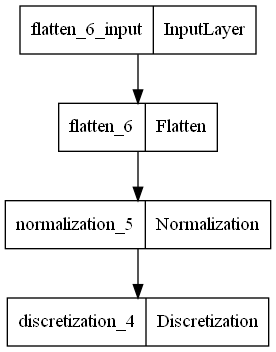

In [14]:
tf.config.list_physical_devices()

model = tf.keras.Sequential([
  flatten,
  normalizer,
  discretizer
])

X_model = model(X_train)
print(X_model[:5])

tf.keras.utils.plot_model(model)

**Categorieke data**

De preprocessing stappen die vaak uitgevoerd worden op categorieke data hebben te maken met hun encoding.
Zo is het bijvoorbeeld nodig om:
* Een numerieke encoding om te zetten naar one-hot, multi-hot of andere voorstellingen. Dit kan met de CategoryEncoding laag.
* Hashing uit te voeren op een categorieke feature om een vector te bekomen
* Een tekstuele categorieke waarde te encoderen zodat het door een neuraal netwerk gelezen kan worden
*  Een integer waarde om te zetten naar een representatie dat gelezen kan worden door een neuraal netwerk

In [19]:
# string to integer
data = tf.constant([["a"], ["b"], ["c"], ["b"], ["c"], ["a"]])
print(data)

lookup = tf.keras.layers.StringLookup(output_mode="int")
lookup.adapt(data)
data2 = lookup(data)
print(lookup(data))

# integer to one-hot
lookup2 = tf.keras.layers.IntegerLookup(output_mode="one_hot")
lookup2.adapt(data2)
data3 = lookup2(data2)
print(data3)


data = tf.constant([["a"], ["b"], ["c"], ["b"], ["c"], ["a"], ["d"], ["e"], ["f"]])
print(lookup2(lookup(data)))

tf.Tensor(
[[b'a']
 [b'b']
 [b'c']
 [b'b']
 [b'c']
 [b'a']], shape=(6, 1), dtype=string)
tf.Tensor(
[[3]
 [2]
 [1]
 [2]
 [1]
 [3]], shape=(6, 1), dtype=int64)
tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]], shape=(6, 4), dtype=float32)
tf.Tensor(
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]], shape=(9, 4), dtype=float32)


**Welke kolom wordt gebruikt voor de onbekenden?**

**Tekstuele data**

Hoe we tot nu toe gewerkt hebben met tekstuele data (zoals een tweet) was om er een bag of words van te maken.
Op basis van deze bag of words kon dan ook een tf-idf waarde berekend worden om rekening te houden met heel vaak voorkomende woorden.
Bij tensorflow kan je iets gelijkaardigs doen door gebruik te maken van de **TextVectorization** laag.
Deze laag krijgt een volledige string mee en kan deze standaardizeren of splitsen op basis van een karakter.
Standaardizeren van een string houdt in dat extra spaties en leestekens verwijderd worden of dat alle hoofdletters omgezet worden naar kleine letters. Als je een andere zaken wil bereiken kan je ook een functie meegeven die opgeroepen wordt voor elke string.

Verder kan de TextVectorization laag ook een bag-of-words berekenen of zelfs een tf-idf waarde berekenen.

In [20]:
data = tf.constant([
        "The. Brain is wider than the Sky",
        "For put them side by. side",
        "The one the other will contain",
        "With ease, and You beside",
])

text_vectorizer = tf.keras.layers.TextVectorization(output_mode="int")
text_vectorizer.adapt(data)

print("Encoded text:", 
      text_vectorizer(["The Brain is deeper than the sea"]).numpy())

Encoded text: [[ 2 19 14  1  9  2  1]]


**Preprocessing van figuren**

Aangezien computervisie een heel belangrijke toepassing is, zijn er een heel breed spectrum van lagen voorzien om te werken met beelden.
Bij Data Augmentation worden er ook nog lagen aangehaald die in principe onder preprocessing lagen vallen maar nu nog minder relevant zijn.
Een aantal andere belangrijke lagen zijn:
* Resizing()
* Rescaling()
* Flatten()
* ...

Een voorbeeld voor te werken met dit soort data wordt getoond onder het Computer Visie gedeelte .

## With Functional API

Het probleem om te werken met het sequentiele model is dat de inputs allemaal van hetzelfde type moeten zijn. 
Dit houdt in dat ze allemaal numeriek of categoriek moeten zijn.
In veel gevallen is dit geen probleem, bijvoorbeeld bij het verwerken van tweets of figuren. 
Indien je werkt met gestructureerde data is dit echter vaak te beperkend.
Om deze reden kan je ook gebruik maken van de functional API.
Zet hierbij het voorbeeld van de numerieke data om zodat het werkt met de functional API ipv het sequentiele model.
Bekijk hiervoor ook de code op het einde van de notebook van vorige les.

(100, 32, 32, 3)
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(5, 3072), dtype=int64)


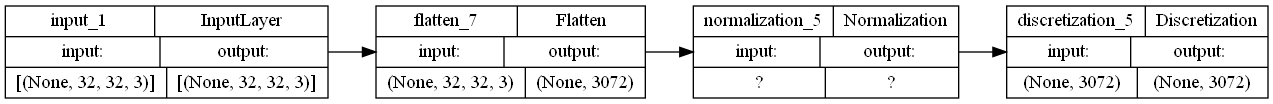

In [21]:
# pas het voorbeeld van de numerieke data aan zodat het werkt met 
# de functional api ipv het sequentieel model
# print hierbij ook de graaf uit

print(X_train.shape)
inputs = tf.keras.Input(shape=X_train.shape[1:])
x = tf.keras.layers.Flatten()(inputs)
x = normalizer(x)
x = tf.keras.layers.Discretization(bin_boundaries=[0])(x)

preprocessor = tf.keras.Model(inputs=inputs, outputs=x)
preprocessor.compile()
x = preprocessor(X_train)

print(x[:5])
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

# Computer visie

Het tweede deel van deze notebook staat in het teken van computer visie.
Dit deel van Machine Learning is tegenwoordig heel populair en behaalt door middel van Deep Learning neurale netwerken heel goede resultaten bij het interpreteren van beelden en video.
De toepassingen van Computer visie zijn omvangrijk, bijvoorbeeld:
* Medische wereld: interpreteren scans, robots om te helpen bij kinesie therapie
* Mobiliteit: Zelfrijdende auto's
* Productie: Magazijnen waar robots zelf items halen of kijken hoe ze iets in elkaar moeten steken
* Gaming: Geavanceerde bots
* Media: Maken en detecteren van deep fakes/misinformatie

In deze domeinen wordt computervisie gebruikt zowel als regressie en classificatie techniek.
Daarnaast zijn ook transformers veel voorkomend. Transformers zijn neurale netwerken die een beeld omzetten in een ander beeld. 
Dit wordt bijvoorbeeld gebruikt voor image segmentation waarbij je kan kijken waar in de figuur welke objecten aanwezig zijn om daarop analyses te doen.

Hier gaan we werken met een standaard classificatieprobleem binnen het domein van computervisie, namelijk de CIFAR10-dataset.
Deze dataset bestaat uit 60000 32x32 kleurbeelden (50000 trainingsdata, 10000 testdata). 
Er zijn 10 mogelijke klassen in deze dataset met 6000 beelden per klasse.
De mogelijke klassen zijn:
* airplane 
* automobile 
* bird 
* cat 
* deer 
* dog 
* frog 
* horse 
* ship 
* truck

Deze oefening gaan we uitwerken in drie stappen:
* Data genereren
* Data augmentation
* Opstellen neuraal netwerk

## Data generation

Laten we beginnen met deze dataset te downloaden van kaggle en te unzippen. Let er hierbij op dat de trainings- en testdata in verschillende mappen geplaatst worden.

In theorie kan je nu alle beelden inladen en gebruiken als data.
Echter is dit snel een grote belasting voor het geheugen van je computer.
Hierdoor kan het beter zijn om de data slechts in stukjes in te lezen.
Dit gebeurd in de code hieronder.

In [22]:
# download
import opendatasets as od
od.download("https://www.kaggle.com/competitions/cifar-10/overview")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading cifar-10.zip to .\cifar-10


100%|██████████| 715M/715M [00:27<00:00, 27.5MB/s] 



Extracting archive .\cifar-10/cifar-10.zip to .\cifar-10


In [18]:
# install for handling 7z
!pip install pyunpack
!pip install patool
!pip install scikit-image


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
     --------------------------------------- 12.0/12.0 MB 27.3 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 35.7 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 33.3 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 32.5 MB/s eta 0:00:00
     ------------------------------------- 208.5/208.5 kB 13.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from pyunpack import Archive
import os

Archive('cifar-10/train.7z').extractall("")
Archive('cifar-10/test.7z').extractall("")
    

In [24]:
from skimage.io import imread
from keras.utils import Sequence
import numpy as np
import pandas as pd


df = pd.read_csv("cifar-10/trainLabels.csv")
labels_train = df.label.to_list()

filenames_train = ["train/" + str(x) + ".png" for x in df.id]
filenames_test = ["test/" + str(x) + ".png" for x in range(10000)]

validation_percentage = 0.9
cutoff = int(len(filenames_train) * validation_percentage)
filenames_val = filenames_train[cutoff:]
filenames_train = filenames_train[:cutoff]
labels_val = labels_train[cutoff:]
labels_train = labels_train[:cutoff]

print(len(filenames_train), "num train images found:", filenames_train[:5])
print(len(filenames_val), "num val images found:", filenames_val[:5])
print(len(filenames_test), "num test images found:", filenames_test[:5])

voc = {"airplane":0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4, "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9}

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([imread(filename) for filename in batch_x]), np.array([voc[lbl] for lbl in batch_y])

batch_size = 32
sequence = CIFAR10Sequence(filenames_train, labels_train, batch_size)
sequence_val = CIFAR10Sequence(filenames_val, labels_val, batch_size)

batch_x, batch_y = sequence.__getitem__(1)
print(batch_x)
print(batch_y)

45000 num train images found: ['train/1.png', 'train/2.png', 'train/3.png', 'train/4.png', 'train/5.png']
5000 num val images found: ['train/45001.png', 'train/45002.png', 'train/45003.png', 'train/45004.png', 'train/45005.png']
10000 num test images found: ['test/0.png', 'test/1.png', 'test/2.png', 'test/3.png', 'test/4.png']
[[[[ 50  64  37]
   [ 51  63  41]
   [ 42  55  41]
   ...
   [ 48  45  42]
   [ 18  18  14]
   [ 14  15  12]]

  [[ 86 107  67]
   [ 92 110  76]
   [ 82  99  67]
   ...
   [ 46  43  41]
   [ 17  17  14]
   [ 11  12  10]]

  [[ 43  60  42]
   [ 43  56  41]
   [ 51  65  46]
   ...
   [ 42  39  37]
   [ 10  10   9]
   [  6   6   5]]

  ...

  [[220 165 151]
   [209 174 165]
   [199 172 164]
   ...
   [177 171 168]
   [176 170 167]
   [175 168 166]]

  [[188 178 162]
   [182 170 162]
   [182 161 157]
   ...
   [176 168 166]
   [175 167 165]
   [174 166 164]]

  [[188 167 162]
   [184 163 157]
   [186 167 160]
   ...
   [176 169 166]
   [176 168 166]
   [173 165 162]]

## Data augmentation

Het verzamelen van voldoende data voor het trainen van Deep Learning computervisie toepassingen kan heel kostelijk worden omdat er vaak heel veel figuren (tienduizenden tot miljoenen) moeten verzameld en gelabeld worden.
Het is dus duidelijk dat dit niet ideaal is.

Een mogelijkheid om de benodigde hoeveelheid voorbeelden/data/figuren te beperken is door kleine wijzigingen aan te brengen aan je bestaande data.
Hierdoor zorg je voor meer variatie wat er voor zorgt dat je model beter kan generaliseren en de klans op overfitting verkleint.
Hierdoor krijg je typisch betere resultaten.
Een voorbeeld hoe je dit kan doen, zie je in onderstaande code.
Let op dat het de bedoeling is dat deze code uiteindelijk deel uitmaakt van de totale pipeline maar hier houden we het nog apart om het resultaat van de augmentatie stappen te kunnen bepalen.

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomBrightness, RandomZoom, Resizing, Rescaling
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt

In [26]:
def draw_figures(data_augmentation, image):
    
    tmp = tf.cast(tf.expand_dims(image, 0), tf.float32)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        if i > 0:
            augmented_image = data_augmentation(tmp)
            plt.imshow(augmented_image[0])
        else:
            plt.imshow(image)
        plt.axis("off")

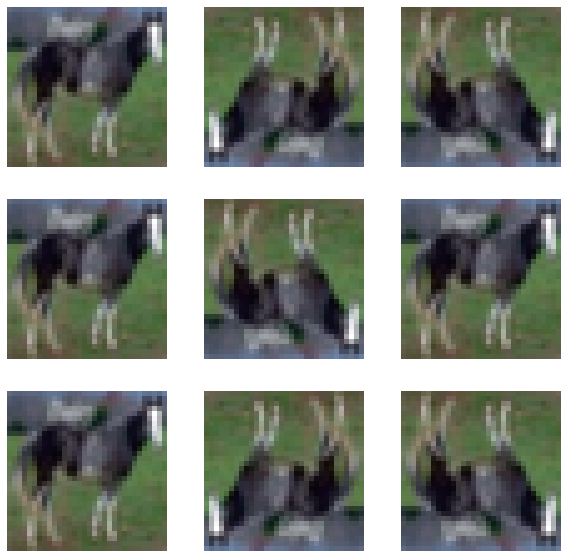

In [27]:
data_augmentation = Sequential([
    Rescaling(1./255),
    RandomFlip()
])

draw_figures(data_augmentation, batch_x[5])

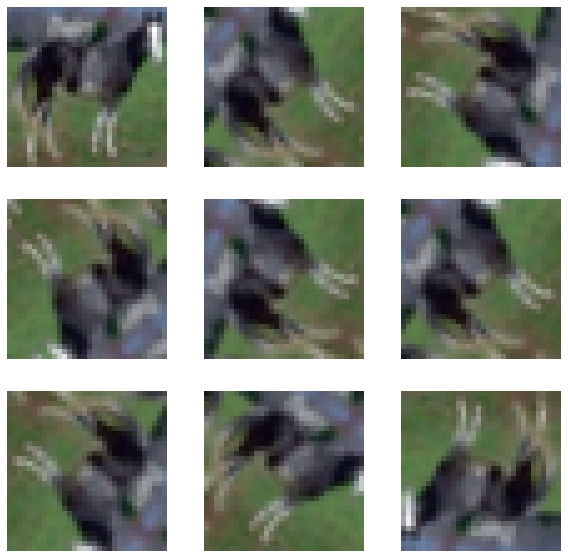

In [28]:
data_augmentation = Sequential([
    Rescaling(1./255),
RandomRotation(factor=3.14/2.0)
])

draw_figures(data_augmentation, batch_x[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


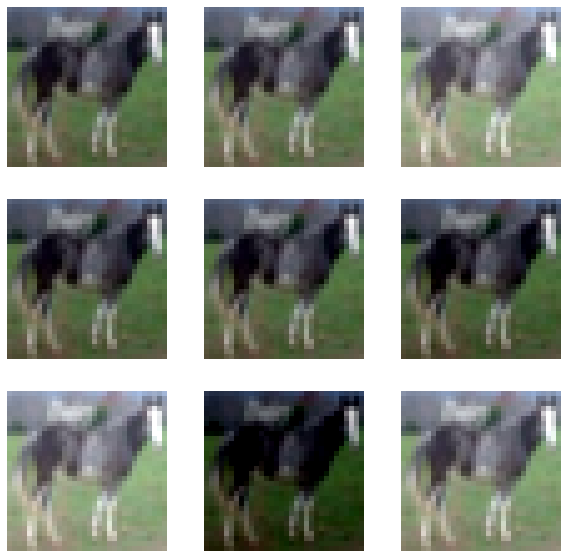

In [31]:
data_augmentation = Sequential([
    Rescaling(1./255),
    RandomBrightness(0.001)
])

draw_figures(data_augmentation, batch_x[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


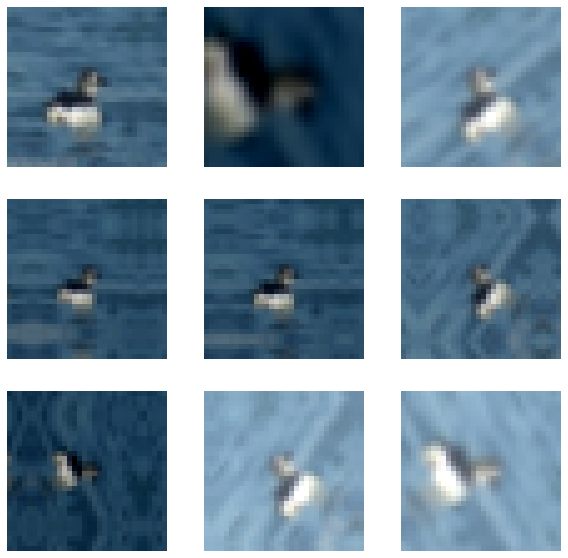

In [33]:
data_augmentation = Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.5),
    RandomBrightness(0.001)
])

draw_figures(data_augmentation, batch_x[15])

## Convolutionele neurale netwerken

Na bovenstaande experimenten is het duidelijk dat er veel meer variatie in de dataset kan gebracht worden.
Bij classificatie problemen kan dit zelden problemen geven.
Let echter op als je kleinere objecten probeert te detecteren.
Indien je dan bijvoorbeeld zoomt of roteert bestaat de kans dat het object niet meer in beeld valt.
Dit zorgt er dan voor dat je foutieve data meegeeft aan het algoritme.
Door de hogere varieteit is dit probleem echter niet zo erg want de kans dat dit vaak voorvalt is klein tenzij je extreme waarden kiest voor de augmentation algoritmes.

## Convolutionele neurale netwerken

Op basis van bovenstaande stappen kunnen we nu een neuraal netwerk opbouwen om deze figuren te classificeren.
Klassiek zou je hier meerdere Dense layers voor gebruiken.
Computer visie is echter een complex probleem waar het onvoldoende is om individuele pixelwaarden te weten voor een goede classificatie uit te voeren.
Indien je dit toch met een klassiek fully-connected neuraal netwerk te doen zou je heel veel neuronen en lagen moeten hebben om deze verbanden goed te capteren.

De state-of-the-art neurale netwerken binnen computer visie plaatsen eerst een aantal lagen voor het neurale netwerken waarbij deze features geextraheerd worden.

Deze neurale netwerken worden Convolutionele Neurale Netwerken genoemd (CNN).
De naam hiervan komt voort uit het feit dat ze gebruik maken van Convolutionele lagen.
Naast deze convolutionele lagen wordt er ook vaak gebruik gemaakt van Pooling lagen om de dimensies te reduceren en zo de performantie te verbeteren.

Een goede uitleg met grafische steuntjes kan je vinden op [deze pagina](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

### Convolutionele lagen

De basis van een convolutionele laag is het concept van een convolutie.
Een convolutie is een mathematische operatie waarbij data uit verschillende bronnen wordt verbonden/samengevoegd.
In beeldverwerking wordt dit al lang gebruikt om bijvoorbeeld een blur-effect te introduceren, ruis te verminderen of randen scherper te maken. 

In neurale netwerken worden Convolutionele lagen gebruikt om randen te detecteren.
In de eerste laag zijn dit letterlijk de randen van de figuur maar dieper liggende lagen detecteren hogere orde features zoals gezichten, banden, ogen, ...

Deze convolutie/feature extraction wordt uitgevoerd door een kernel. Dit is een kleine matrix die een aantal pixelwaarden samenvoegd met bepaalde gewichten. Deze gewichten worden getrained.
Let wel op dezelfde kernel gebruikt wordt voor een hele feature-map. Hierdoor wordt het aantal gewichten beperkt.

Bij het opstellen van een convolutionele laag moet je een aantal zaken kiezen. Deze keuzes bepalen de dimensies van de outputlaag en de structuur van de onderliggende lagen dus je bestudeerd best de dimensies van de in- en output van deze lagen om vlot te kunnen werken.

De hyperparameters van een convolutionele laag zijn:
* Dimensies van de input
    * 1D -> convolutie in de tijd
    * 2D -> convolutie over beelden
    * 3D -> convolutie over volumes, bvb video (images in de tijd) of 3d-modellen bij medische beeldvorming
* De kernel-dimensie: hoe groot is het venster waarin pixels samengevoegd worden
    * Typisch 3x3 of 5x5 (deze getallen zijn oneven zodat er een centrum pixel is, normaal ook gelijk in beide dimensies maar dat is niet verplicht)
    * Hoe kleiner de figuur hoe kleiner je je kernel wilt. Het is belangrijk om lokale data te gebruiken
* De stride: Hoeveel waarden/pixels schuift de kernel op elke stappen
    * Vaak 1 maar kan ook 2 of 3 zijn
* Padding: Hoe vang je de gevallen op dat de kernel buiten de figuur zou komen
    * No-padding: Kernel kan niet buiten de randen van de figuur gaan (valid padding in tensorflow). Hierdoor kan de dimensie van de output verkleind worden
    * Zero-Padding: Nullen worden toegevoegd indien de kernel buiten de randen van de figuur zou gaan (same padding in tensorflow)
* Aantal kernels: Hoeveel keer dat we deze convolutie willen uitvoeren = aantal "feature maps" die uit de laag komen
* Activation function
* Regularizers

Omdat een aantal van deze operaties de grootte van de figuren beinvloed gaan we dit eerst inoefenen aan de hand van een aantal voorbeelden.
Hierbij gaan we uit van de figuren die we hierboven berekend hebben die RGB beelden zijn (drie kanalen) van 32x32 pixels.

Wat is de output van een convolutionele laag met de hyperparameters:
* 1 kernel, Kernel=3x3, stride=1, padding = zero/same padding

In [34]:
from tensorflow.keras.layers import Conv2D
image = tf.cast(tf.expand_dims(batch_x[5], 0), tf.float32)

convolutie = Conv2D(1, 3, 1, "same")
convolutie(image).shape

TensorShape([1, 32, 32, 1])

* 5 kernel, Kernel=3x3, stride=1, padding = no/valid padding

In [35]:
convolutie = Conv2D(5, 3, 1, "valid")
convolutie(image).shape

TensorShape([1, 30, 30, 5])

* 5 kernel, Kernel=5x5, stride=2, padding = zero/same padding

In [36]:
convolutie = Conv2D(5, 5, 2, "same")
convolutie(image).shape

TensorShape([1, 16, 16, 5])

* 5 kernel, Kernel=5x5, stride=2, padding = no/valid padding

In [37]:
convolutie = Conv2D(5, 5, 2, "valid")
convolutie(image).shape

TensorShape([1, 14, 14, 5])

### Pooling lagen

Een probleem/beperking met het concept van convolutionele lagen is dat kleine beweging van de feature resulteren in een andere feature map/andere output. 
Dit komt omdat de convolutie de exacte positie van de feature bijhoudt.

De impact van deze kleine veranderingen (die bijvoorbeeld de impact zijn van onze augmentaties) wordt typisch vermeden door down-sampling uit te voeren. 
Hierdoor bekomen we een lagere resolutie waar echter nog steeds de belangrijkste en grootste features in gecapteerd zijn. 

In neurale netwerken kan deze downsampling uitgevoerd worden door de stride van de convolutie doorheen het beeld te vergroten.
Dit is echter een niet zo robuste aanpak en typisch wordt er gekozen om gebruik te maken van een pooling laag.

Dit is een laag die toegevoegd wordt na de activatiefunctie van de convolutionele laag.
Deze pooling laag voert dan deze downsampling uit door een bepaalde operatie uit te voeren.
Veruit de meest gebruikte operaties hiervoor zijn:
* Average pooling: Gemiddelde feature aanwezig in de buurt
* Maximum pooling: Sterkste, meest prominente, meest duidelijke feature

Deze operatie op zich voert nog geen downsampling uit.
Het downsamplen komt voort uit het feit dat deze laag een kleine groep pixels bekijkt (kernel/filter) en dit kijkvenster met een bepaalde stap verschuift (stride).
**In bijna alle gevallen wordt gebruik gemaakt van een 2x2 venster dat verschuift met een stap van 2.**
Dit houdt in dat de dimensie van de input gehalveerd wordt door het toepassen van een pooling laag


In [39]:
from tensorflow.keras.layers import MaxPooling2D

Indien we een standaard MaxPooling laag (filter of 2x2 en stride of 2) uitvoeren op de originele figuur (32x32x3), welke dimensie heeft de output dan?

In [40]:
pooling = MaxPooling2D()
pooling(image).shape

TensorShape([1, 16, 16, 3])

### Full example

Een Convolutioneel Neuraal Netwerken bestaat uit dus eerst 1 of meerdere Convolutionele lagen gevolgd door een Pooling laag. 
Deze twee lagen worden afgewisseld tot je denkt voldoende diepte te hebben. Dit hangt af van de input van je netwerk en wat je probeert te bereiken. 
Wanneer er gestopt wordt met de convolutionele en pooling lagen is er een Flatten layer.
Deze laag doet niet zo veel behalve de dimensie van de tensor aanpassen zodat het een 1-dimensionele rij wordt.
Dit kan dan als input dienen voor een fully-connected neuraal netwerk bestaande uit 1 of meerdere Dense lagen.

Een voorbeeld waar een volledig CNN uitgelegd worden kan je [hier](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480) bestuderen.
Hieronder gaan we het voorbeeld waarmee we hierboven begonnen waren verder afwerken.


In [41]:
model = Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomBrightness(0.001),
    Conv2D(5, 3, 1, "same"),   # 5 kernels ,3 x3 met een stride van 1
    MaxPooling2D()
])

model(image)

<tf.Tensor: shape=(1, 16, 16, 5), dtype=float32, numpy=
array([[[[ 0.1280379 , -0.05710467, -0.07674482,  0.17105009,
           0.10257881],
         [ 0.0965445 ,  0.02386383, -0.10905522,  0.04905855,
           0.10421901],
         [ 0.02948923,  0.03200268, -0.02947416, -0.01883185,
           0.06888105],
         ...,
         [ 0.08669673, -0.02165976, -0.04724876, -0.1068137 ,
           0.05025973],
         [ 0.0579398 , -0.01355752, -0.02627344, -0.05635013,
           0.05299176],
         [ 0.05601827, -0.03235475, -0.03845108,  0.01157841,
           0.0697997 ]],

        [[ 0.13360636, -0.05145695, -0.05221586,  0.16740568,
           0.10082085],
         [ 0.13257924, -0.0882095 , -0.09023482,  0.08662311,
           0.15191577],
         [ 0.10305645, -0.07219458, -0.08745809,  0.06118656,
           0.1428468 ],
         ...,
         [ 0.09413126, -0.14241713, -0.14994273,  0.00304579,
           0.07190771],
         [ 0.08971699, -0.03241025, -0.06352192, -0.04

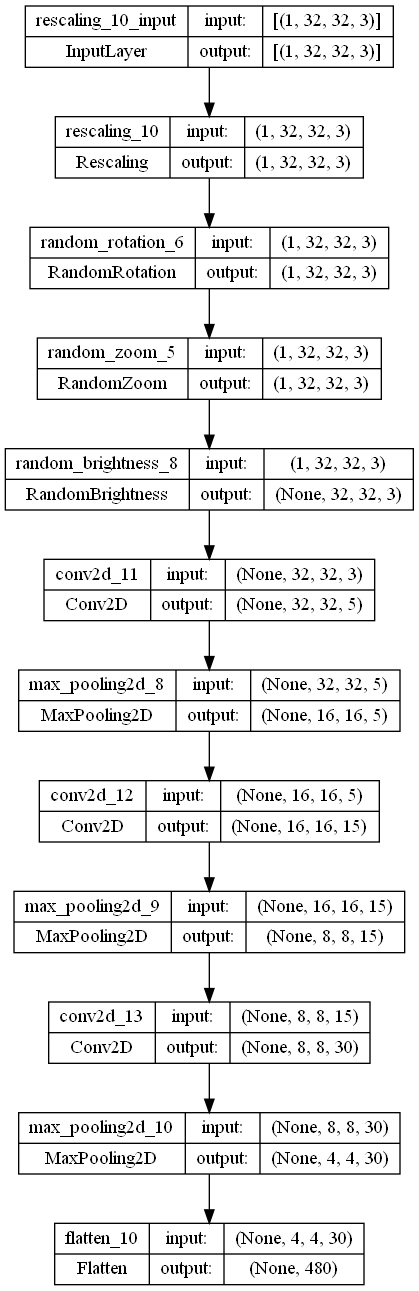

In [44]:
from tensorflow.keras.layers import Flatten

model = Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomBrightness(0.001),
    Conv2D(5, 3, 1, "same"),
    MaxPooling2D(),
    Conv2D(15, 3, 1, "same"),
    MaxPooling2D(),
    Conv2D(30, 3, 1, "same"),
    MaxPooling2D(),
    Flatten()
])

model(image)

# we beginnen met 32 x 32
# we doen 3 max pooling die het gaat halveren
# dus eigenlijk delen door 2^3 = 8
# op het einde na de maxpooling heb je 30 kernels van 4x4 -> 480 waarden per beeld

tf.keras.utils.plot_model(model, show_shapes=True)

In [45]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (1, 32, 32, 3)            0         
                                                                 
 random_rotation_6 (RandomRo  (1, 32, 32, 3)           0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (1, 32, 32, 3)            0         
                                                                 
 random_brightness_8 (Random  (None, 32, 32, 3)        0         
 Brightness)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 5)         140       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 5)      

In [47]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import time

model = Sequential([
    Rescaling(1./255),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomBrightness(0.001),
    Conv2D(5, 3, 1, "same"),
    MaxPooling2D(),
    Conv2D(15, 3, 1, "same"),
    MaxPooling2D(),
    Conv2D(30, 3, 1, "same"),
    MaxPooling2D(),
    Flatten(),
    Dense(1000, activation="relu"),
    Dense(10, activation="sigmoid") # number of classes
])

# output test of the model 
model(image)

# train
model.compile(optimizer="adam", loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

logdir="logs\\fit\\" + str(int(time.time()))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=10, profile_batch=0)


In [ ]:
# Launch TensorBoard with objects in the log directory
# This should launch tensorboard in your browser, but you may not see your metadata.
# do this in commandline
# tensorboard --logdir="C:\Users\jens.baetens3\OneDrive - ODISEE\MACHINE_LEARNING\Leerstof\Lessen\Week 3\logs\fit"

# met tandwieltje kan je auto updates aanzetten waarmee je een lopende run kan monitorren


Epoch 1/5


c:\Users\jens.baetens3\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1407/1407 [==============================] - 140s 96ms/step - loss: 1.6674 - accuracy: 0.4026 - val_loss: 1.4100 - val_accuracy: 0.5026
Epoch 2/5
1407/1407 [==============================] - 138s 98ms/step - loss: 1.4354 - accuracy: 0.4920 - val_loss: 1.3967 - val_accuracy: 0.5262
Epoch 3/5
1407/1407 [==============================] - 136s 97ms/step - loss: 1.3359 - accuracy: 0.5289 - val_loss: 1.2371 - val_accuracy: 0.5644
Epoch 4/5
1407/1407 [==============================] - 136s 97ms/step - loss: 1.2563 - accuracy: 0.5567 - val_loss: 1.3024 - val_accuracy: 0.5556
Epoch 5/5
1407/1407 [==============================] - 135s 96ms/step - loss: 1.2031 - accuracy: 0.5766 - val_loss: 1.1597 - val_accuracy: 0.5876


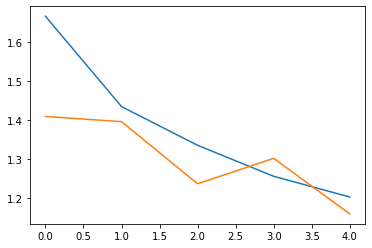

In [48]:
history = model.fit(sequence, batch_size= 32, epochs= 5,
          validation_data=sequence_val,
          shuffle=True,
          callbacks=[tensorboard_callback ])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])